In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
L=12

def KeyConvert(key):
    key_dist = []
    
    for k in range(len(key)):
        entry = key[len(key)-k-1]
        if entry == '1':
            key_dist.append(1.)
            
        if entry == '0':
            key_dist.append(0.)
    return np.array(key_dist)

def MatchRex(r):
    sym = '0'
    if r < 0.:
        sym = '1'
    return sym

def ReadZ(results,RexList):
    prob_dist = np.array([0. for x in range(L)])
    counter = 0.
    
    for key in results:
        counter += results.get(key,0.)
        prob_dist += results.get(key,0.)*(1.-2.*KeyConvert(key))*RexList

    return prob_dist/ counter

def ReadZZ(results,RexList):
    prob_dist = np.array([0. for x in range(L)])
    counter = 0.
    
    for key in results:
        counter += results.get(key,0.)
        Ze = (1.-2.*KeyConvert(key))*RexList
        prob_dist += results.get(key,0.)*Ze * np.roll(Ze,1)

    return prob_dist/ counter


In [2]:
physics_results = []
mit_results = []
RexRecord = []
vac_results = []
mit_vac_results = []

ElectricSim=np.load('electric_ev.npy')
QuarkSim=np.load('quark_ev.npy')

for tstep in range(1,14,1):
    f = open("SU2_L12_String_step"+str(tstep)+"_data.json")
    data = json.load(f)
    physics_results.append(data['physics_results'])
    mit_results.append(data['mit_results'])
    RexRecord.append(data['RexSign'])

    vac_results.append(data['physics_results_r'])
    mit_vac_results.append(data['mit_results_r'])

    
theory_mit = [1. for x in range(L)]
StringStart = 5
StringEnd = 8
for x in range(StringStart,StringEnd):
    theory_mit[x] = -1
    
theory_mitZZ = [1. for x in range(L)]
theory_mitZZ[StringStart] = -1
theory_mitZZ[StringEnd] = -1

In [3]:
#Bootstrapped Errors
ntwirl = len(RexRecord)
#Prepares <Z> for the bootstrap
physics_list = []
mit_list = []

physics_vac_list = []
mit_vac_list = []

physicsZZ_list = []
mitZZ_list = []

physicsZZ_vac_list = []
mitZZ_vac_list = []

for t in range(len(physics_results)):
    physics_listT = []
    mit_listT = []

    physics_vac_listT = []
    mit_vac_listT = []

    physicsZZ_listT = []
    mitZZ_listT = []

    physicsZZ_vac_listT = []
    mitZZ_vac_listT = []
    for n in range(len(physics_results[t])):
        physics_circuits = ReadZ(physics_results[t][n],RexRecord[t][n])
        mitigation_circuits = theory_mit*ReadZ(mit_results[t][n],RexRecord[t][n])
    
        physics_listT.append(physics_circuits)
        mit_listT.append(mitigation_circuits)
    
        physics_vac_circuits = ReadZ(vac_results[t][n],RexRecord[t][n])
        mitigation_vac_circuits = ReadZ(mit_vac_results[t][n],RexRecord[t][n])

        physics_vac_listT.append(physics_vac_circuits)
        mit_vac_listT.append(mitigation_vac_circuits)
    
        physics_circuits = ReadZZ(physics_results[t][n],RexRecord[t][n])
        mitigation_circuits = theory_mitZZ*ReadZZ(mit_results[t][n],RexRecord[t][n])
        physicsZZ_listT.append(physics_circuits)
        mitZZ_listT.append(mitigation_circuits)
    
        physics_vac_circuits = ReadZZ(vac_results[t][n],RexRecord[t][n])
        mitigation_vac_circuits = ReadZZ(mit_vac_results[t][n],RexRecord[t][n])

        physicsZZ_vac_listT.append(physics_vac_circuits)
        mitZZ_vac_listT.append(mitigation_vac_circuits)
        
    physics_list.append(physics_listT)
    mit_list.append(mit_listT)
    
    physics_vac_list.append(physics_vac_listT)
    mit_vac_list.append(mit_vac_listT)
    
    physicsZZ_list.append(physicsZZ_listT)
    mitZZ_list.append(mitZZ_listT)
    
    physicsZZ_vac_list.append(physicsZZ_vac_listT)
    mitZZ_vac_list.append(mitZZ_vac_listT)

In [4]:
#Computes <Z> errors with correlated bootstrap
import random
NBoot = 2000

PSub = []
PSubErr = []

QSub = []
QSubErr = []

TotalQ = []
TotalQErr = []

def BootSample(physlist,mitlist):
    nsample = len(physlist)
    tcircuit = random.randint(0,nsample-1)
    PhysSample = np.copy(physlist[tcircuit])
    MitSample = np.copy(mitlist[tcircuit])

    for n in range(nsample - 1):
        tcircuit = random.randint(0,nsample-1)
        PhysSample += physlist[tcircuit]
        MitSample += mitlist[tcircuit]
        
    PhysSample = PhysSample / nsample
    MitSample = MitSample / nsample
    
    return PhysSample / MitSample
    
for t in range(len(physics_list)):
    PSubLT = []
    QSubLT = []
    QTotalT = []
    for b in range(NBoot):    
        deco_boot = BootSample(physics_list[t],mit_list[t])
        deco_vac_boot = BootSample(physics_vac_list[t],mit_vac_list[t])
    
        
        #'''
        for x in range(L):
            if deco_boot[x] > 1.:
                deco_boot[x] = 1.
            if deco_vac_boot[x] > 1.:
                deco_vac_boot[x] = 1.
            
            if deco_boot[x] < -1.:
                deco_boot[x] = -1.
            if deco_vac_boot[x] < -1.:
                deco_vac_boot[x] = -1.
        #'''
        
        PSubLT.append(-0.5*(deco_boot - deco_vac_boot))
        #PSubLT.append(-0.5*(deco_boot - 1.))
    
        deco_bootZZ = BootSample(physicsZZ_list[t],mitZZ_list[t])
        deco_vac_bootZZ = BootSample(physicsZZ_vac_list[t],mitZZ_vac_list[t])
    
        #'''
        for x in range(L):
            if deco_bootZZ[x] > 1.:
                deco_bootZZ[x] = 1.
            if deco_vac_bootZZ[x] > 1.:
                deco_vac_bootZZ[x] = 1.
            
            if deco_bootZZ[x] < -1.:
                deco_bootZZ[x] = -1.
            if deco_vac_bootZZ[x] < -1.:
                deco_vac_bootZZ[x] = -1.
        #'''
        QSubLT.append(0.5*(deco_vac_bootZZ-deco_bootZZ))
        #QSubLT.append(0.5*(1.-deco_bootZZ))
        QTotalT.append(np.sum(0.5*(deco_vac_bootZZ-deco_bootZZ)/2))

    PSubT = np.mean(PSubLT,axis=0)
    PErrT = np.std(PSubLT,axis=0)
        
    QSubT = np.mean(QSubLT,axis=0)
    QErrT = np.std(QSubLT,axis=0)
    
    PSub.append(PSubT)
    PSubErr.append(PErrT)
    
    QSub.append(QSubT)
    QSubErr.append(QErrT)
    
    TotalQ.append(np.mean(QTotalT))
    TotalQErr.append(np.std(QTotalT))

<ipython-input-4-b4340763fccc>:28: RuntimeWarning: divide by zero encountered in divide
  return PhysSample / MitSample


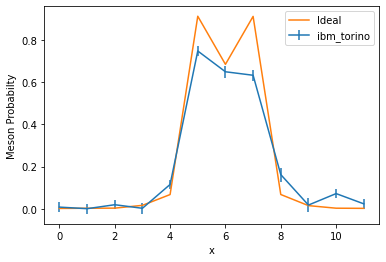

In [5]:
t=7
plt.errorbar([x for x in range(L)],PSub[t],xerr=None,yerr=PSubErr[t],label='ibm_torino')
plt.plot(ElectricSim[t], label="Ideal")
plt.xlabel('x')
plt.ylabel('Meson Probabilty')
plt.legend()
#plt.savefig('string_break_torino_12steps_rot.png')

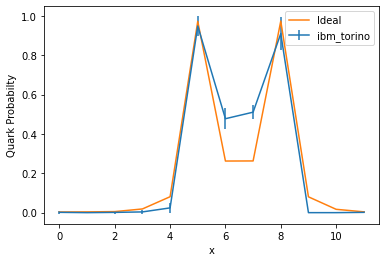

In [6]:
plt.errorbar([x for x in range(L)],QSub[t],xerr=None,yerr=QSubErr[t],label='ibm_torino')
plt.plot(QuarkSim[t], label="Ideal")
plt.xlabel('x')
plt.ylabel('Quark Probabilty')
plt.legend()

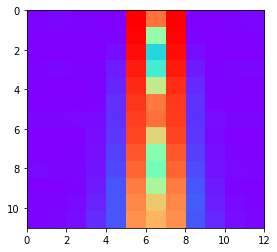

In [7]:
dt=0.5
NStep=12
plt.imshow(ElectricSim,cmap='rainbow',extent=[0,L,dt*NStep*2,0])

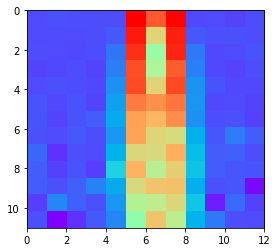

In [8]:
plt.imshow(PSub,cmap='rainbow',extent=[0,L,dt*NStep*2,0])

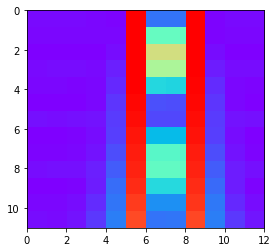

In [9]:
plt.imshow(QuarkSim,cmap='rainbow',extent=[0,L,dt*NStep*2,0])

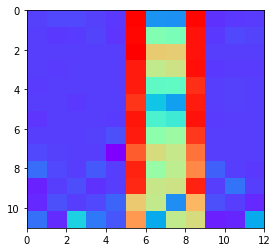

In [10]:
plt.imshow(QSub,cmap='rainbow',extent=[0,L,dt*NStep*2,0])

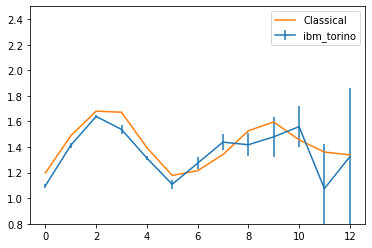

In [12]:
TotalQSim = [np.sum(QuarkSim[t])/2 for t in range(len(QuarkSim))]
plt.errorbar([x for x in range(len(TotalQ))],TotalQ,xerr=None,yerr=TotalQErr,label='ibm_torino')
plt.plot([x for x in range(len(TotalQSim))],TotalQSim,label='Classical')
plt.ylim([0.8,2.5])
plt.legend()